In [163]:
%matplotlib notebook
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

### Introduction

Our script has finished collecting data on all used cars for sale from https://carfromjapan.com. This dataset includes mostly Japanese domestic market (JDM) cars from the 1990s or older. 

Let's load in the data and take a quick look at the column data types.

In [164]:
JDM_df = pd.read_csv('JDM_car_data_v2.csv')

In [165]:
JDM_df

,Unnamed: 0,num_pics,discount,model,body_type,date,km,engine_cc,grade,price,trans,fuel_type,seats,num_doors,steering,drive_type,dim,ext_color
0,0,29,0.13,Nissan Skyline,sedan,1972Jul,28000.0,2000,NaN,52553,Manual,Petrol,5,4,-,2WD,15,Green
1,0,35,0.20,Nissan Skyline,sedan,1989Jan,25000.0,2000,4.5,15934,Automatic,Petrol,-,2,-,-,15,White
2,0,52,0.52,Nissan Skyline,sedan,1971Nov,8000.0,2000,4,77445,Manual,Petrol,-,5,-,-,15,-
3,0,28,0.02,Nissan Skyline,sedan,1983Sep,95000.0,2000,3,18909,Manual,Petrol,-,3,-,-,15,Gun_metallic
4,0,20,0.20,Toyota Crown,sedan,1989Feb,55000.0,2000,4.5,15573,Automatic,Petrol,5,4,-,2WD,15,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59062,0,51,0.21,Mitsubishi Fuso Canter,truck,2007Jan,238200.0,4900,NaN,-,Automatic,Diesel,-,2,Right,2WD,-,White
59063,0,43,0.01,Mitsubishi Fuso Canter,truck,2010Mar,290000.0,4900,NaN,-,Manual,Diesel,-,2,Right,2WD,-,Blue
59064,0,19,0.16,Mitsubishi Fuso Canter,truck,2008Jul,205200.0,4900,NaN,-,Manual,Diesel,-,4,Right,2WD,-,White
59065,0,60,0.60,Hino Ranger,truck,2007Sep,566000.0,6400,NaN,-,Manual,Diesel,-,2,Right,2WD,-,Black


In [166]:
JDM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59067 entries, 0 to 59066
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  59067 non-null  int64  
 1   num_pics    59067 non-null  int64  
 2   discount    59067 non-null  float64
 3   model       59067 non-null  object 
 4   body_type   59067 non-null  object 
 5   date        59067 non-null  object 
 6   km          58259 non-null  float64
 7   engine_cc   59067 non-null  int64  
 8   grade       27598 non-null  object 
 9   price       59067 non-null  object 
 10  trans       59067 non-null  object 
 11  fuel_type   59067 non-null  object 
 12  seats       59067 non-null  object 
 13  num_doors   59067 non-null  object 
 14  steering    59067 non-null  object 
 15  drive_type  59067 non-null  object 
 16  dim         59067 non-null  object 
 17  ext_color   59067 non-null  object 
dtypes: float64(2), int64(3), object(13)
memory usage: 8.1+ MB


### Data Cleaning

First, we must standardize all of the column data types to a set of numerical-only predictors for training the machine learning algorithms. Making sure the predictors are numerical is important because this is the only way a machine learning algorithm can understand the data we are feeding it, assuming our software will not automatically create dummy variables.  


**NOTE:** There will be no data imputation performed in this step. This will be done after the dataset has been split for training and testing.

In [167]:
def clean_all_data(df):
    
    # Create df copy
    cdf = df.copy()
    
    # Convert dash character to NaN
    cdf.replace('-', np.nan, inplace=True)
    
    # Create new variables by splitting columns
    cdf['registration_year'] = cdf.date.str.extract('(\d+)')
    cdf['registration_month'] = cdf.date.str.extract('([a-zA-Z]+)')
    cdf['manufacturer'] = cdf.model.str.split(' ', expand=True)[0]
    
    # Convert string columns to numeric
    cdf['price'] = pd.to_numeric(cdf['price'])
    cdf['seats'] = pd.to_numeric(cdf['seats'])
    cdf['num_doors'] = pd.to_numeric(cdf['num_doors'])
    cdf['dim'] = pd.to_numeric(cdf['dim'])
    cdf['registration_year'] = pd.to_numeric(cdf['registration_year'])
    cdf['registration_month'] = pd.to_datetime(cdf.registration_month, format='%b').dt.month
    
    # After manual review, found many trucks and vans mislabeled as other body types
    cdf.loc[cdf['model'].str.contains('Truck'), 'body_type'] = 'truck'
    cdf.loc[cdf['model'].str.contains('Van'), 'body_type'] = 'minivan'
    
    # Remove unnecessary column
    cdf.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    return cdf

JDM_df = clean_all_data(JDM_df)

# Remove all cars that do not have a price listed
JDM_df = JDM_df[JDM_df['price'].notnull()]

In [168]:
JDM_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48865 entries, 0 to 59046
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_pics            48865 non-null  int64  
 1   discount            48865 non-null  float64
 2   model               48865 non-null  object 
 3   body_type           48865 non-null  object 
 4   date                48865 non-null  object 
 5   km                  48349 non-null  float64
 6   engine_cc           48865 non-null  int64  
 7   grade               26734 non-null  object 
 8   price               48865 non-null  float64
 9   trans               48862 non-null  object 
 10  fuel_type           48862 non-null  object 
 11  seats               35356 non-null  float64
 12  num_doors           48473 non-null  float64
 13  steering            21377 non-null  object 
 14  drive_type          28802 non-null  object 
 15  dim                 48865 non-null  float64
 16  ext_

 Our data still contains many nulls; however, we have changed all possible string variables into integer variables--at least those that do not require dummy variables. 
 
 Before encoding our categorical variables, we will first perform a quick exploratory data analysis (EDA) to avoid creating too many unnecessary features. We may hold off on engineering a feature if there are too many missing values.

### Exploratory Data Analysis

EDA is an important step in the Data Science pipeline where we try to uncover patterns in the data, identify potentially important variables, and check our assumptions before creating our predictive models.

First, we will look at the distribution of our target variable or the variable we are trying to predict: car price.

<IPython.core.display.Javascript object>


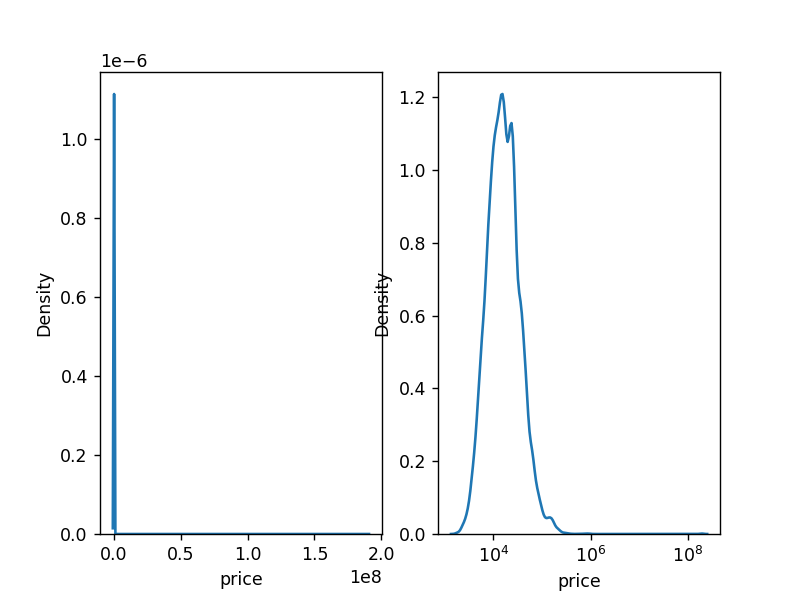

count    4.886500e+04
mean     4.557323e+04
std      2.105362e+06
min      1.763000e+03
25%      9.575000e+03
50%      1.578200e+04
75%      2.627100e+04
max      1.900328e+08
Name: price, dtype: float64

In [169]:
f, axes = plt.subplots(1,2)

sns.kdeplot(data=JDM_df, x='price', ax=axes[0])
sns.kdeplot(data=JDM_df, x='price', log_scale=True, ax=axes[1])

JDM_df['price'].describe()

Above, we have created two density plots for our target variable. Not surprisingly, our variable is heavily skewed to the right. This is common among variables measured in currency such as house prices, incomes, etc...

Right skewed means that our distribution is being heavily skewed by outliers towards the right of the distribution. In other words, there are a few cars with extremely high prices which is inflating our mean. For example, the highest car price seems to be around \\$190M while our median is only around \\$15,000.

**NOTE:** After reviewing the website, I found that a few cars were listed under two different prices. Specifically, I found 6 cars which all had prices greater than \\$100M but a second price which was usually around \\$20,000. These 6 cars will be considered as erroneous entries and removed from the dataset since it is unlikely a used vehicle has such a high price.

In [170]:
JDM_df.sort_values('price', ascending=False).head(n=50)

,num_pics,discount,model,body_type,date,km,engine_cc,grade,price,trans,fuel_type,seats,num_doors,steering,drive_type,dim,ext_color,registration_year,registration_month,manufacturer
35473,21,0.21,Mercedes-Benz M-Class,coupe,1988Jun,91200.0,6000,NaN,190032760.0,Automatic,Petrol,4.0,3.0,Left,NaN,999970.00,Other,1988,6.0,Mercedes-Benz
12197,21,0.21,Mercedes-Benz M-Class,minivan,1988Jun,91200.0,6000,NaN,190032760.0,Automatic,Petrol,4.0,3.0,Left,NaN,999970.00,Other,1988,6.0,Mercedes-Benz
34192,21,0.21,Mazda Savanna RX-7,convertible,1989Nov,104000.0,650,NaN,190019185.0,Manual,Petrol,2.0,2.0,Right,NaN,999970.00,Black,1989,11.0,Mazda
11921,21,0.21,Mazda Savanna RX-7,minivan,1989Nov,104000.0,650,NaN,190019185.0,Manual,Petrol,2.0,2.0,Right,NaN,999970.00,Black,1989,11.0,Mazda
39686,10,0.10,Suzuki Carry Truck,truck,2003Mar,53100.0,660,NaN,189997739.0,Manual,Petrol,2.0,2.0,Right,4WD,999970.00,White,2003,3.0,Suzuki
19452,10,0.10,Suzuki Carry Truck,truck,2003Mar,53100.0,660,NaN,189997739.0,Manual,Petrol,2.0,2.0,Right,4WD,999970.00,White,2003,3.0,Suzuki
51968,21,0.21,Nissan Atlas,truck,2016Feb,40700.0,2000,NaN,927868.0,Automatic,Petrol,3.0,2.0,Right,NaN,26.85,White,2016,2.0,Nissan
41234,21,0.21,Toyota Pixis Van,minivan,2020Dec,11300.0,660,NaN,924666.0,Automatic,Petrol,NaN,5.0,Right,NaN,10.00,Black,2020,12.0,Toyota
47330,21,0.21,Honda N-WGN,mini_vehicle,2017Nov,44100.0,660,NaN,924666.0,Cvt,Petrol,NaN,5.0,Right,NaN,10.00,Black,2017,11.0,Honda
39379,21,0.21,Daihatsu Hijet Truck,truck,2020Jul,34000.0,660,NaN,924666.0,Manual,Petrol,NaN,2.0,Right,4WD,10.00,White,2020,7.0,Daihatsu


<IPython.core.display.Javascript object>


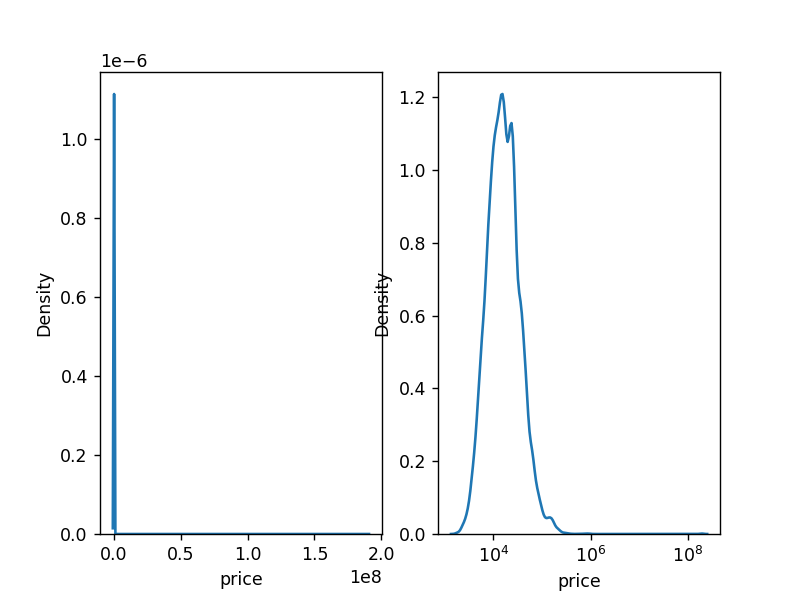

count     48859.000000
mean      22244.341616
std       25443.479664
min        1763.000000
25%        9575.000000
50%       15777.000000
75%       26270.000000
max      927868.000000
Name: price, dtype: float64

In [171]:
f, axes = plt.subplots(1,2)

sns.kdeplot(data=JDM_df, x='price', ax=axes[0])
sns.kdeplot(data=JDM_df, x='price', log_scale=True, ax=axes[1])

# Removes 6 cars mentioned above
JDM_df = JDM_df[JDM_df['price'] < 100000000]
JDM_df['price'].describe()

Let's create some scatter plots to look at the relationship between our target variable and other predictors.

<IPython.core.display.Javascript object>


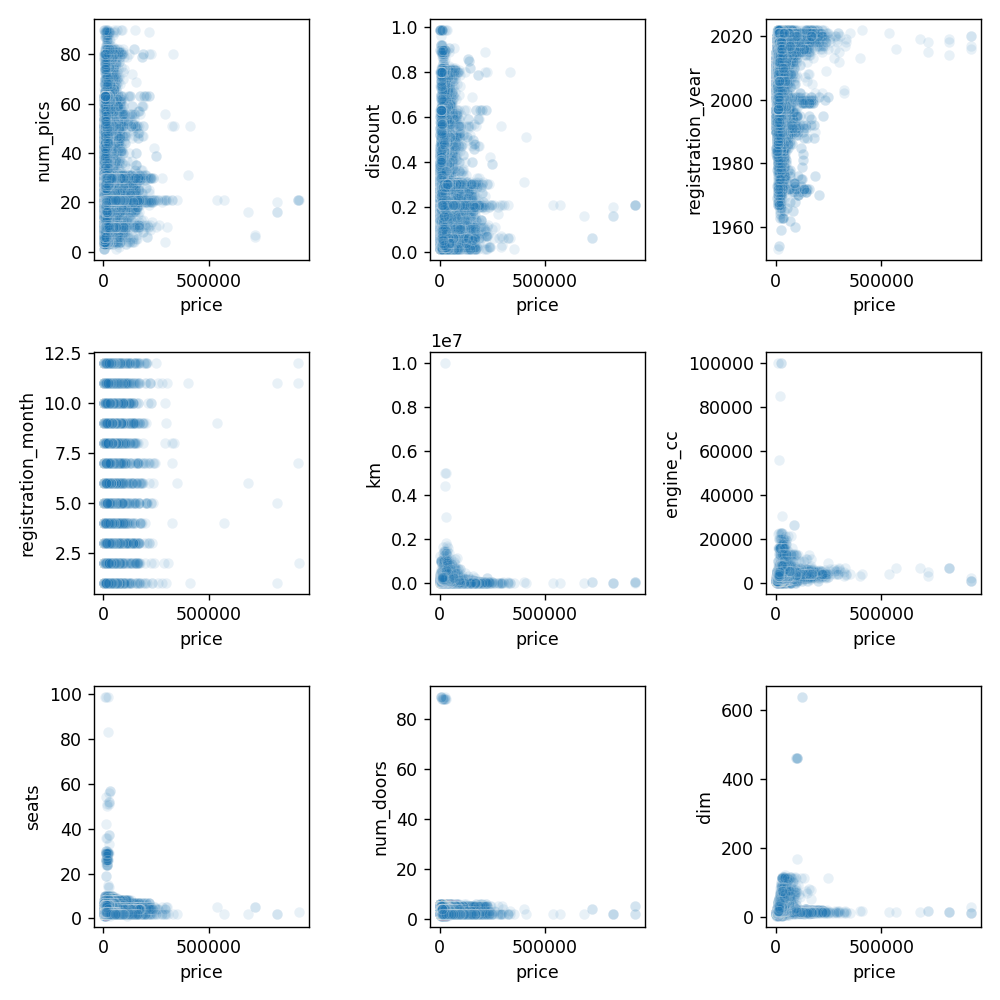

In [172]:
# subset of numerical variables
n_val = JDM_df[['num_pics', 'discount', 'registration_year', 'registration_month',
              'km', 'engine_cc', 'seats', 'num_doors', 'dim', 'price']]


fig = plt.figure('Price vs Numerical Variables',figsize=(8,8))

# loop through numerical columns and
# create scatter plots (price vs numerical)
for index in range(len(n_val.columns)):
    if n_val.columns[index] != 'price':
        plt.subplot(3,3,index+1)
        sns.scatterplot(y=n_val.iloc[:,index], x='price', data=n_val, alpha=.1)
fig.tight_layout()


In general, there does not seem to be a very strong linear relationship between any variable and price.

There does seem to be a clear relationship between registration year and the floor of price. In other words, only cars 2010 or newer comprise the most expensive cars in our data set. This is fairly easy to believe.

Additionally, cars with the biggest engines, the most seats, and the most doors all are priced on the lower side of the price distribution. This is most likely due to these cars being old, used trucks. 

The number of pictures a post has and how much it is discounted seem to have no relationship with price. These columns will be removed before the modeling step to avoid data leakage (i.e. we won't know how much a car will be discounted and how many pics a post has before the car is posted).

Next we will look at how our categorical variables are distributed.

<IPython.core.display.Javascript object>


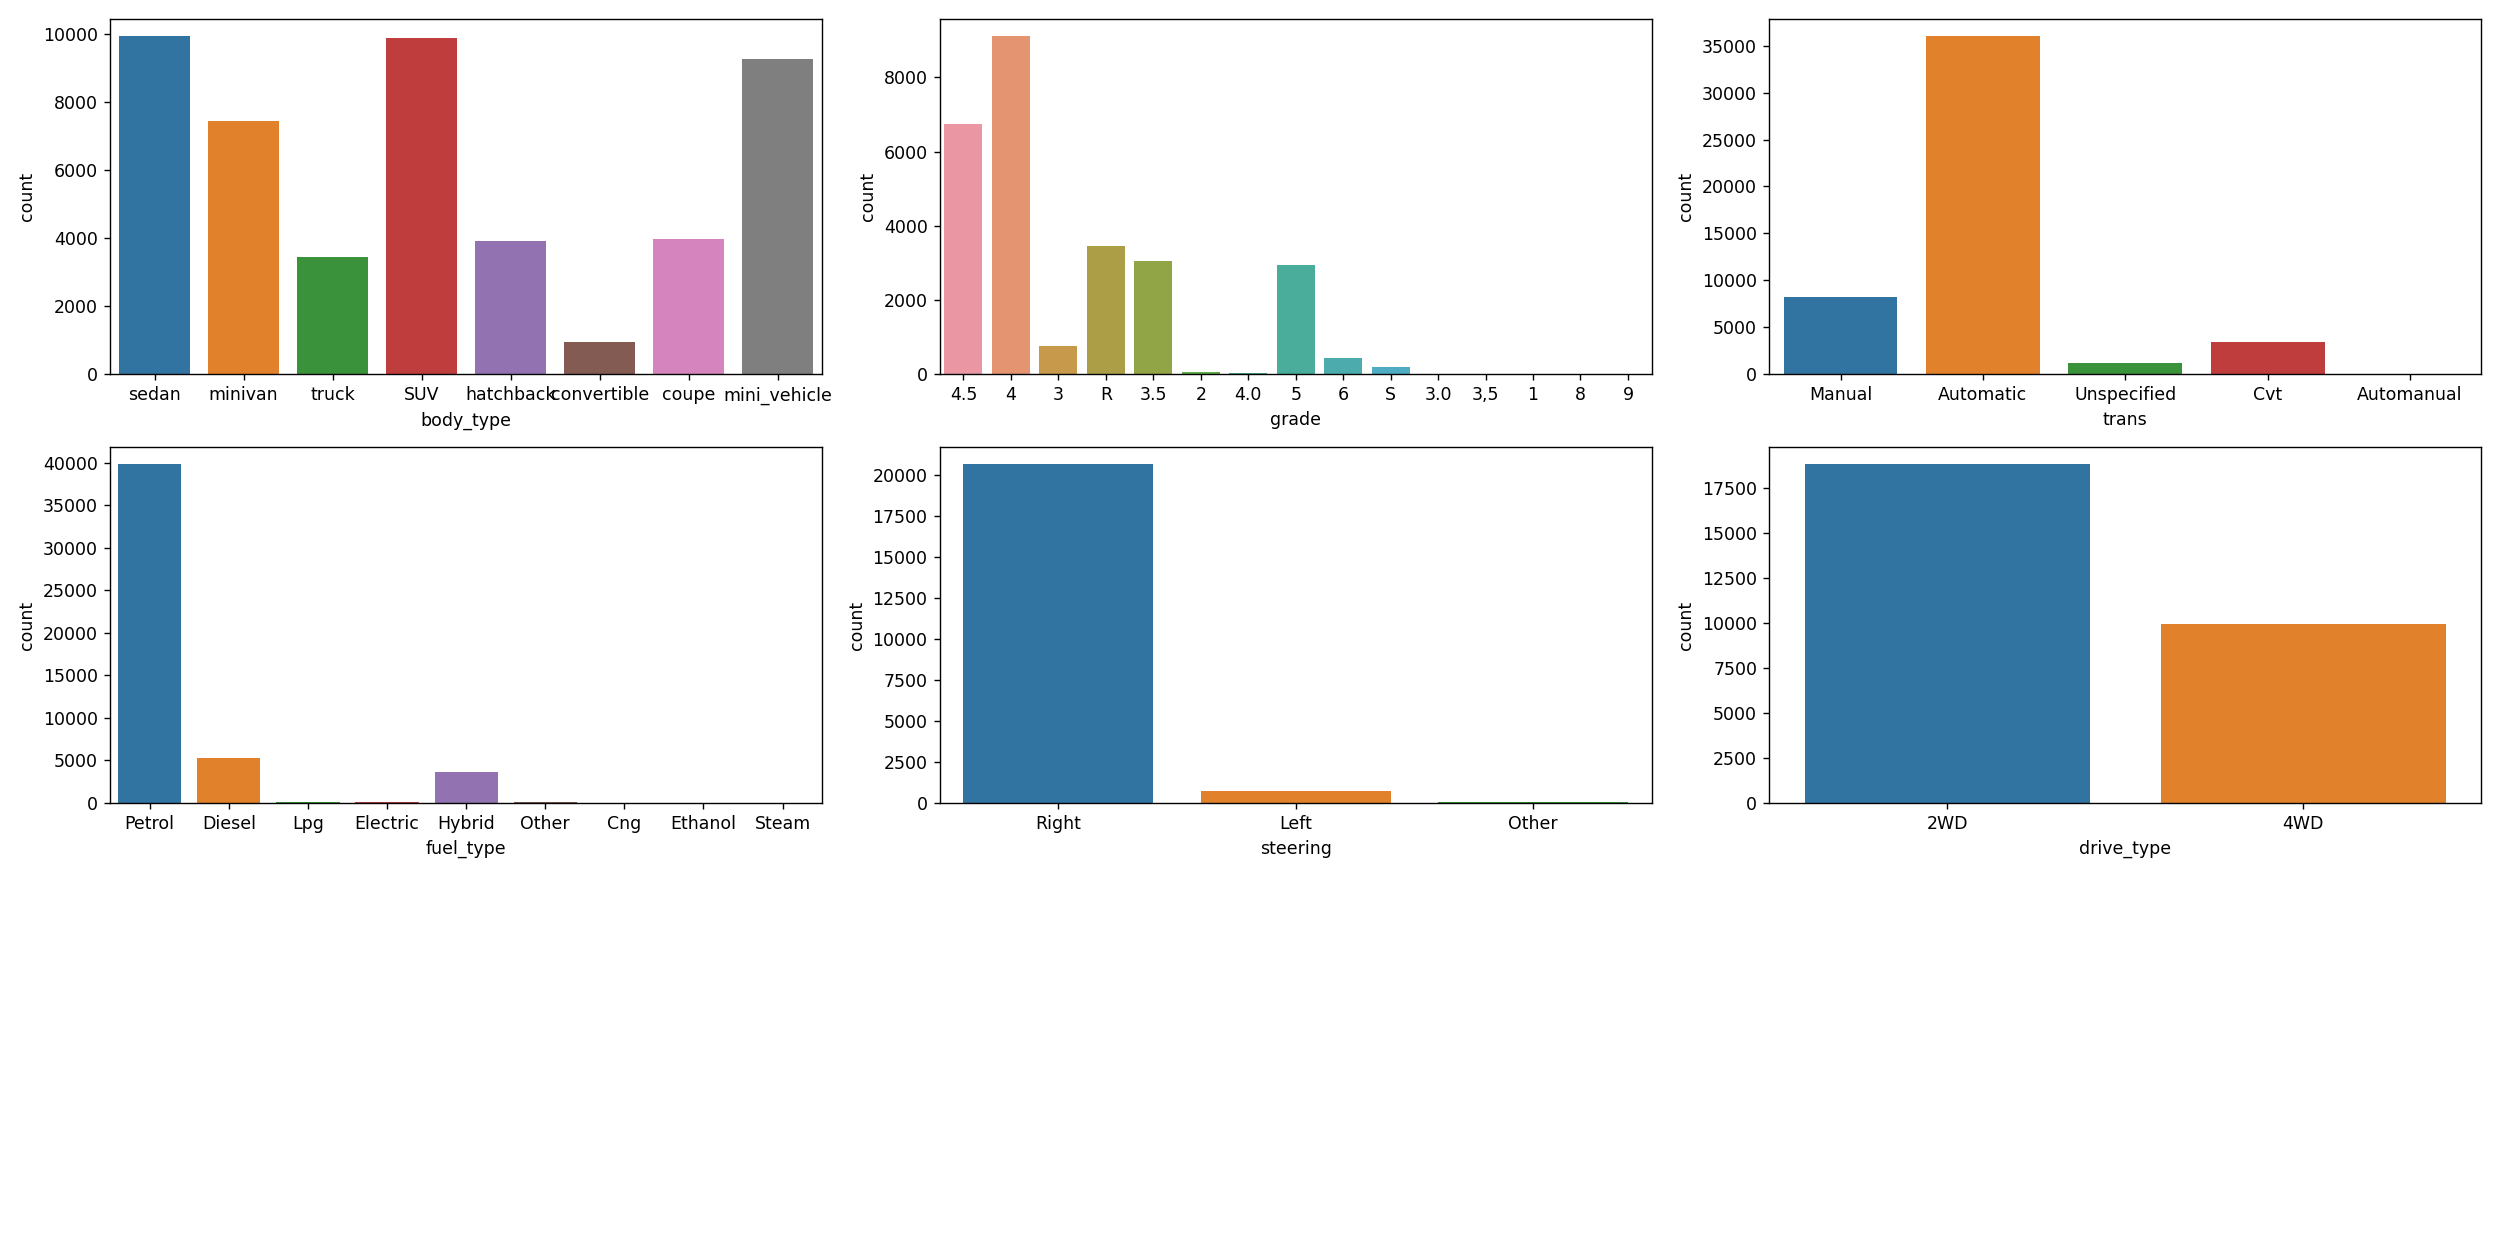

In [173]:
# subset of numerical variables
c_val = JDM_df[['body_type', 'grade', 'trans', 'fuel_type',
                'steering', 'drive_type']]


fig_cat = plt.figure('Price vs Categorical Variables',figsize=(20,10))

# loop through categorical values and
# create scatter plots
for index in range(len(c_val.columns)):    
    plt.subplot(3,3,index+1)
    sns.countplot(x=c_val.iloc[:,index], data=c_val.dropna())

fig_cat.tight_layout()


#### Interpreting Categorical Data Analysis

**body_type**
There seems to be more or less an even distribution across all body types, except for convertible. Truck, hatchback and coupe are also slightly lower than the rest of the body types but not to a concerning degree. 

**grade:**
According to the website's documentation, any grade that is 6 or higher are all interpreted as brand new and less than 12 months old. This means any grade higher than 6 will be changed to 6. Additionally, grade R will be changed to 0, since it signifies a car with repair history. This will allow us to change grade to a numeric column.

**trans:**
Most cars are either manual or automatic, so we will probably not encode for the other types of transmission. I am surprised that there are many more automatics than manual since older cars tend to be manual.

**fuel_type:**
Since most cars use petrol, diesel, are hybrid, we will not be encoding other fuel types. It is interesting that there was one car in our dataset with a fuel type of "steam". This is most likely a translation or input error.

**steering:**
Not surprisingly, most of the cars in our dataset have the steering wheel on the right (Japan drives on the right of the road). We will remove the variable since it contains the same value for virtually all rows.

**drive_type:**
There are around double the amount of 2WD vehicles than there are 4WD. This is not surprising as the website sells older, used cars, which are overwhelmingly 2WD.


#### Price Distribution by Categorical Variables

<IPython.core.display.Javascript object>


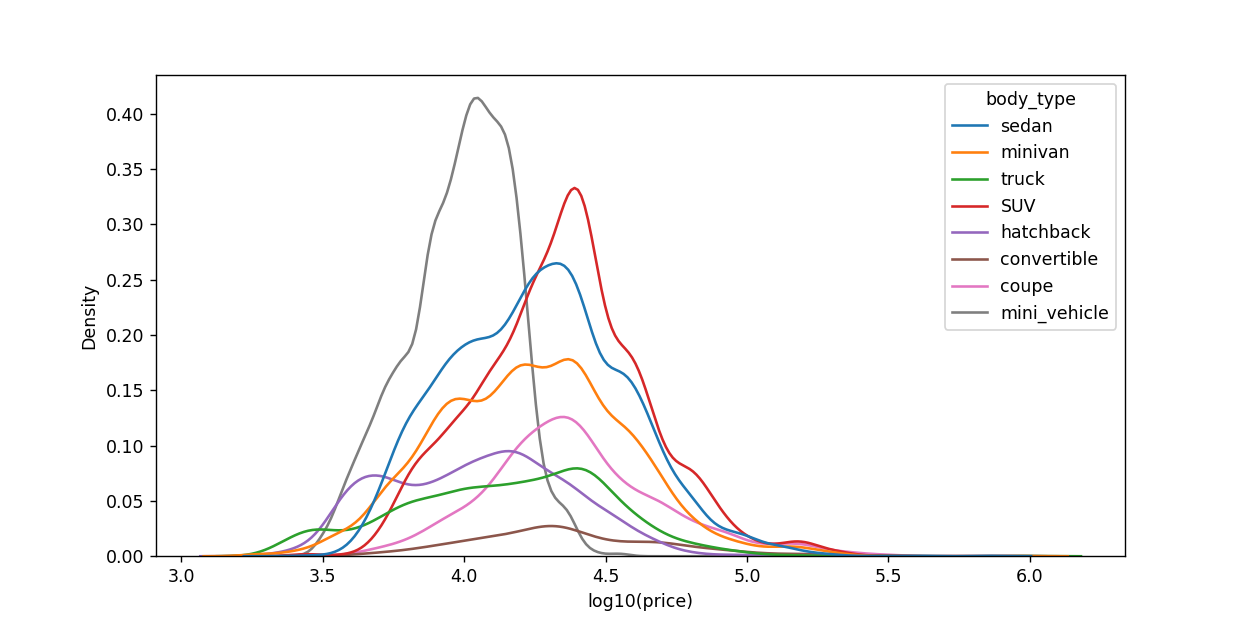

In [174]:
fig_dist_body = plt.figure('Price Distribution by body_type',figsize=(10,5))

sns.kdeplot(data=JDM_df, x=np.log10(JDM_df.price), hue='body_type')
plt.xlabel('log10(price)')
plt.show()

Not surprisingly, mini vehicles are cheaper than other types of vehicles on average. Mini vehicles includes cars which are even smaller than hatchbacks such as Smart cars and Subaro Vivios.

The rest of the body types seem to have similar modes though with varying levels of kurtosis. 

<IPython.core.display.Javascript object>


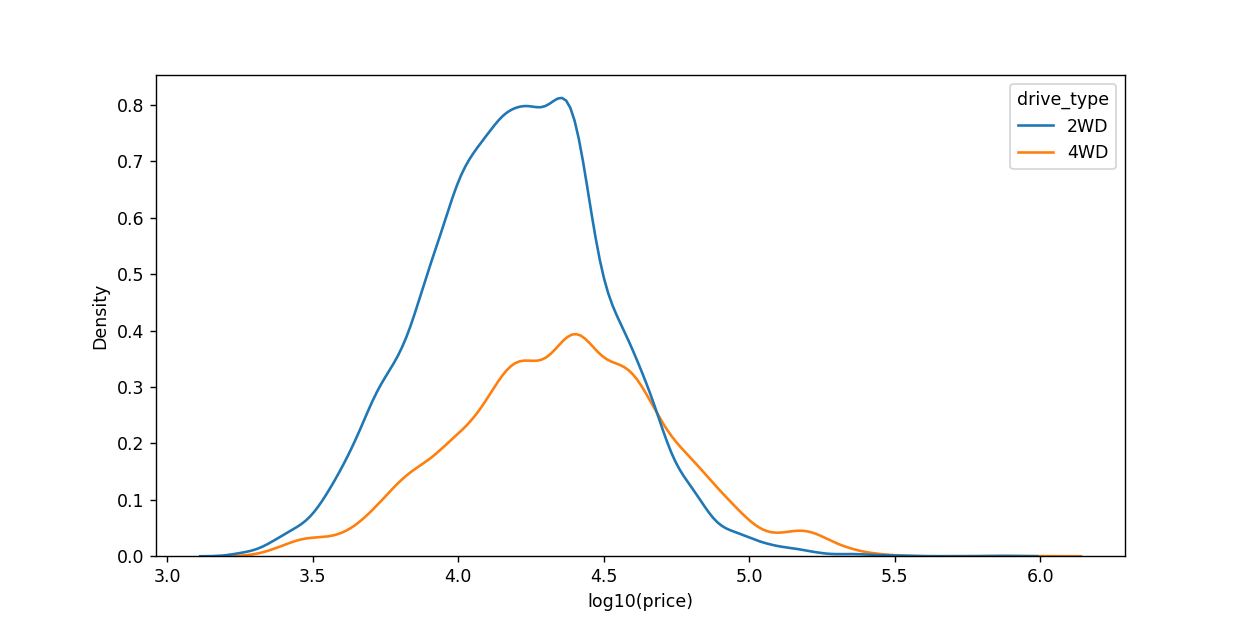

In [175]:
fig_dist_drive = plt.figure('Price Distribution by drive_type',figsize=(10,5))

sns.kdeplot(data=JDM_df, x=np.log10(JDM_df.price), hue='drive_type')
plt.xlabel('log10(price)')
plt.show()

There seems to be a slight difference on the average price of a car based on its drive type; however, this difference is not too large.

### Missing Values

Before engineering new variables, we will look at which variables have the most missing values, and if they need to be dropped.

In [176]:
percent_missing = JDM_df.isnull().sum() * 100 / len(JDM_df)
percent_missing

num_pics               0.000000
discount               0.000000
model                  0.000000
body_type              0.000000
date                   0.000000
km                     1.056100
engine_cc              0.000000
grade                 45.283366
price                  0.000000
trans                  0.006140
fuel_type              0.006140
seats                 27.648949
num_doors              0.802309
steering              56.259850
drive_type            41.054872
dim                    0.000000
ext_color              0.740908
registration_year      0.000000
registration_month    23.461389
manufacturer           0.000000
dtype: float64

`grade`, `seats`, and `drive_type` all have alarming amounts of missing data. 

Since we are dealing with used cars, it is probably safe to assume that most missing values in drive_type are 2WD. Similarly, the average value for `seat` is around 4, which would likely be a fitting value to fill NaNs with; most cars in the dataset are comprised of body types that usually bring 4 seats.

However, I suspect it will be more difficult to fill null values for `grade` since this variable could be greatly influenced by other factors we are not aware of (e.g. seasonality, macroeconomic conditions, etc...). There may be a possibility of including this variable after meeting with subject-matter experts.

`grade` will be removed at the end of this notebook.

### Encode Categorical Variables

We need to one-hot encode variables for including them in our correlation analysis.

In [177]:
# Function that one-hot encodes variables 
# based on a subset of acceptable values
def one_hot_encode(JDM, col, vals):
    
    df = JDM.copy()
    
    for val in vals:
        
        # Return 1 if the current row[col] has the same value as val
        # else return 0
        df[val] = df.apply(lambda row: 1 if row[col] == val else 0, axis=1)
    return df


# We will not be using sklearn's LabelEncoder since our dataset still contains missing values
for col in ['body_type', 'trans', 'drive_type', 'fuel_type' ,'grade']:
    if col == 'body_type':
        JDM_df = one_hot_encode(JDM_df, col, ['sedan', 'minivan', 'truck', 'SUV', 
                                             'hatchback', 'convertible', 'coupe', 'mini_vehicle'])
    if col == 'trans':
        JDM_df = one_hot_encode(JDM_df, col, ['Manual', 'Automatic', 'Cvt'])
    if col == 'drive_type':
        JDM_df = one_hot_encode(JDM_df, col, ['2WD', '4WD'])
        # One-hot encode all drive variables
        
    if col == 'fuel_type':
        JDM_df = one_hot_encode(JDM_df, col, ['Petrol', 'Diesel', 'Hybrid'])
        
    if col == 'grade':
        # Replace 3,5 and R with 3.5 and 0, respectively
        JDM_df['grade'] = JDM_df['grade'].replace(['3,5', 'R', 'S'], ['3.5', '0', '6'])
        
        # Convert grade column to numeric
        JDM_df['grade'] = pd.to_numeric(JDM_df['grade'])
        
        # Convert all grades > 6 to 6
        JDM_df.loc[JDM_df['grade'] > 6, 'grade'] = 6
    
    

### Pearson Correlation Coefficient

<IPython.core.display.Javascript object>


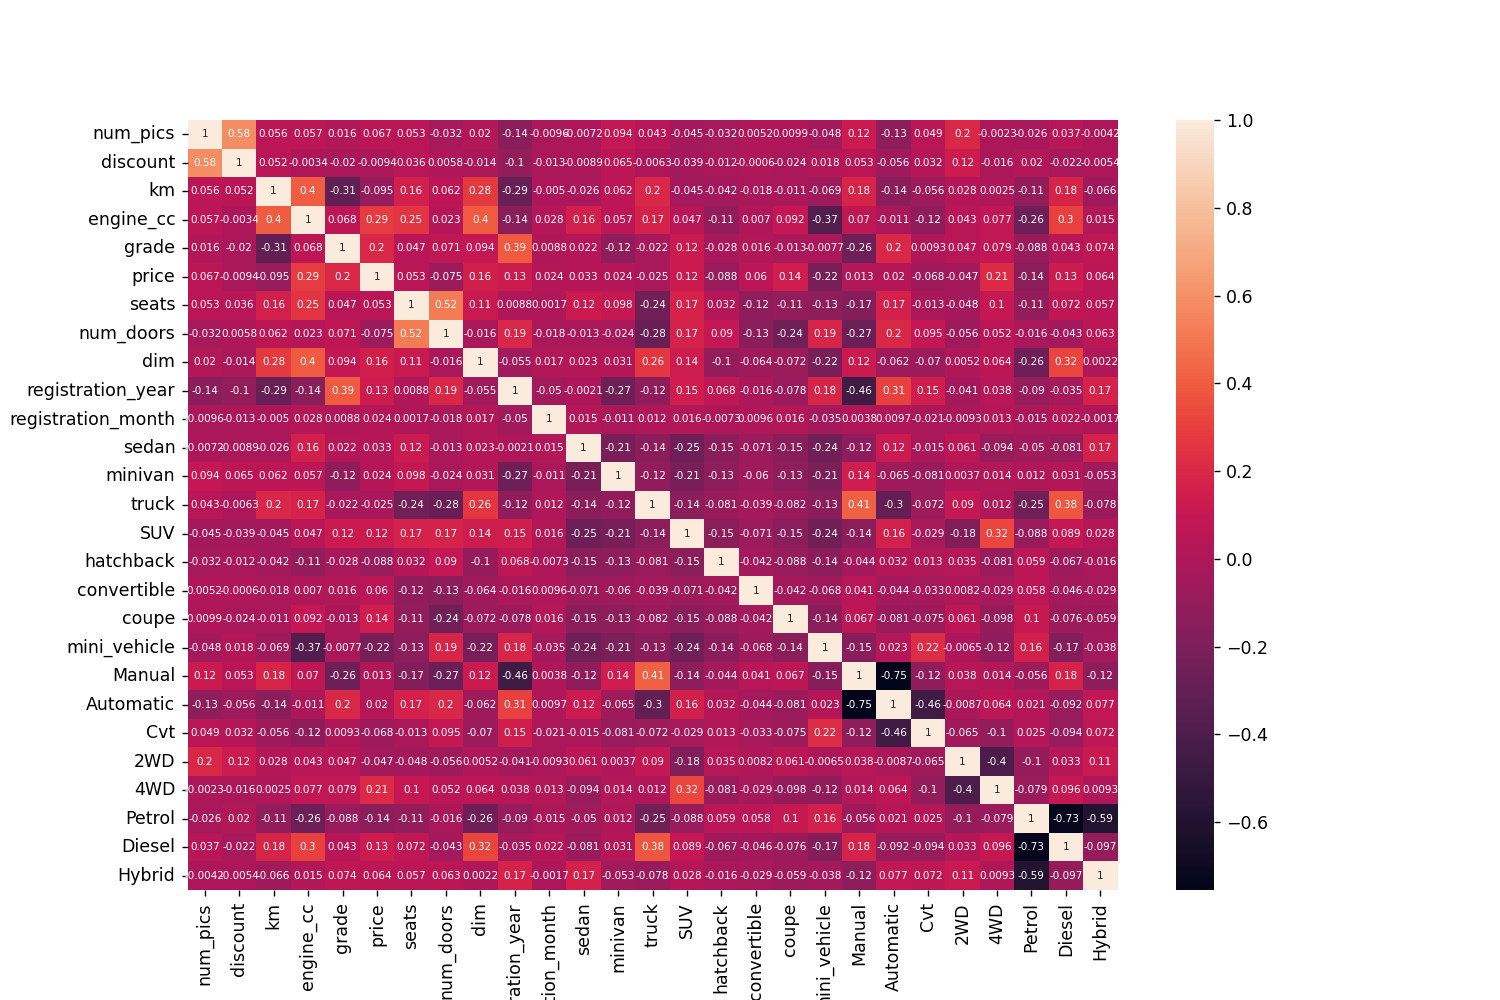

In [178]:
fig_p_corr = plt.figure('Pearson Correaltion Matrix',figsize=(12,8))

pear_corr = JDM_df.corr()

sns.heatmap(pear_corr, annot=True, annot_kws={'size': 6})
plt.show()

#### Interpreting Correlation Results

fkljsa;fldsa

### Principal Components Analysis

Principal components analysis (PCA) is a dimensionality reduction technique that creates a smaller set of new features that best summarize the original set of features. All of the new features or components generated by PCA are linearly uncorrelated.

We will perform PCA on our dataset to see how samples relate to one another when plotted on the first two components and see how much each feature contributes to each principal component.


In [179]:
# Create Imputer object
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Continuous vars
cont_vars = ['km', 'engine_cc', 'grade', 'seats', 'num_doors', 'dim', 'registration_year', 'registration_month',
            'num_pics', 'discount']

# Impute missing values using mean
JDM_df_imputed = pd.DataFrame(imp_mean.fit_transform(JDM_df[cont_vars]))
JDM_df_imputed.columns = JDM_df[cont_vars].columns
JDM_df_imputed.index = JDM_df[cont_vars].index

# Create n components that explain at least 95% of the variance
pca = PCA(n_components = 0.95)

# Fit and transform
pca.fit(JDM_df_imputed)
reduced = pca.transform(JDM_df_imputed)

One component is enough to explain at least 95% of the variance, so we will force sklearn to create at least two components for plotting purposes.

In [180]:
pca = PCA(n_components = 2)

pca.fit(JDM_df_imputed)
reduced = pca.transform(JDM_df_imputed)

In [181]:
pca.explained_variance_ratio_

array([9.99715184e-01, 2.84778883e-04])

<IPython.core.display.Javascript object>


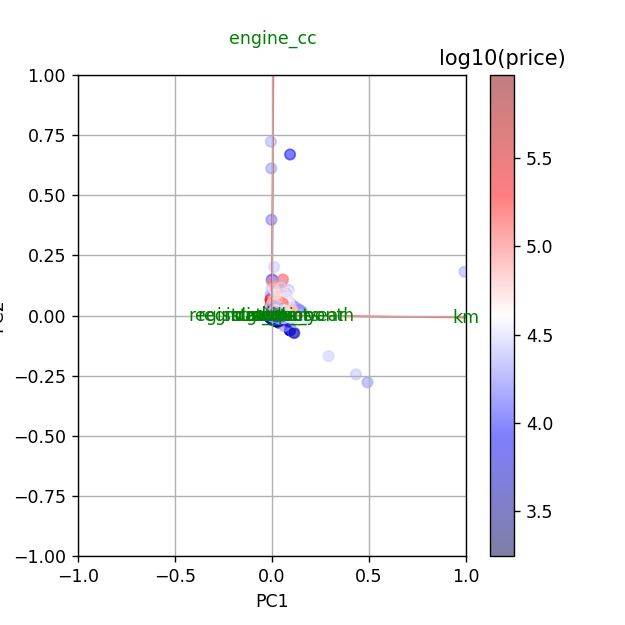

In [182]:
pca_fig = plt.figure('PCA biplot',figsize=(5,5))


# Function that create pca biplot and colors samples using log(price)
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = np.log10(JDM_df.price), cmap='seismic', alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1, coeff[i,1] * 1.15 , labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    clb = plt.colorbar()
    clb.ax.set_title('log10(price)')
    plt.grid()

#Call the function. Use only the 2 PCs.
biplot(reduced[:,0:2],np.transpose(pca.components_[0:2, :]), cont_vars)
plt.show()

The first component explains 99% of the variance while the second component explains less than 1%. This is likely due to the `km` variable having outliers which is skewing our PCA results. Let's remove the outlier and rerun our PCA analysis.

Below, we can see that there is a car listed as having 9 million miles. According to (https://www.everlance.com/blog/10-highest-mileage-vehicles), the current Guiness World Record for the highest vehicle milage is 3 million (~ 4.8 million kilometers). It is not unlikely that this record was erroneously entered.

Additionally, there seems to be outliers in `engine_cc` as well. According to (https://www.autoevolution.com/news/with-two-65-liters-engines-and-4600-hp-this-is-the-worlds-biggest-truck-139285.html), the BelAz truck has an engine capacity of 65 liters (6500 cubic centimeters). This is a 300-ton truck used for large-scale mining operations. Any trucks or cars with engine capacities higher than 6500 are likely misentries.

In [183]:
JDM_df.describe()

,num_pics,discount,km,engine_cc,grade,price,seats,num_doors,dim,registration_year,...,coupe,mini_vehicle,Manual,Automatic,Cvt,2WD,4WD,Petrol,Diesel,Hybrid
count,48859.000000,48859.000000,4.834300e+04,48859.000000,26734.000000,48859.000000,35350.000000,48467.000000,48859.000000,48859.000000,...,48859.000000,48859.000000,48859.000000,48859.000000,48859.000000,48859.000000,48859.000000,48859.000000,48859.000000,48859.000000
mean,24.455740,0.194536,6.147935e+04,1979.367445,3.675713,22244.341616,4.464498,4.122351,13.943200,2011.441147,...,0.081520,0.189627,0.167953,0.738288,0.069588,0.385620,0.203831,0.815346,0.107493,0.073149
std,12.666488,0.137601,9.313635e+04,1705.959688,1.515205,25443.479664,2.001011,1.821834,9.291583,9.036453,...,0.273635,0.392010,0.373828,0.439571,0.254454,0.486746,0.402849,0.388020,0.309742,0.260384
min,1.000000,0.010000,2.500000e+01,0.000000,0.000000,1763.000000,1.000000,1.000000,1.000000,1953.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.090000,2.400000e+04,660.000000,3.500000,9575.000000,4.000000,3.000000,10.000000,2008.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,21.000000,0.200000,4.620000e+04,2000.000000,4.000000,15777.000000,5.000000,5.000000,12.650000,2014.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,30.000000,0.250000,7.895000e+04,2500.000000,4.500000,26270.000000,5.000000,5.000000,16.000000,2018.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,0.990000,9.999999e+06,99999.000000,6.000000,927868.000000,99.000000,89.000000,638.300000,2022.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [184]:
JDM_df.sort_values('km', ascending=False).head(6)

,num_pics,discount,model,body_type,date,km,engine_cc,grade,price,trans,...,coupe,mini_vehicle,Manual,Automatic,Cvt,2WD,4WD,Petrol,Diesel,Hybrid
57300,19,0.19,Other All Other All,truck,2001Oct,9999999.0,99999,NaN,23550.0,Unspecified,...,0,0,0,0,0,0,1,0,0,0
22330,81,0.81,Suzuki Jimny,SUV,2021,5000000.0,660,NaN,29272.0,Automatic,...,0,0,0,1,0,0,1,1,0,0
40002,41,0.41,Suzuki Jimny,mini_vehicle,2022,5000000.0,660,NaN,23784.0,Automatic,...,0,1,0,1,0,0,1,1,0,0
22313,33,0.33,Suzuki Jimny,SUV,2021,4400000.0,660,NaN,26835.0,Automatic,...,0,0,0,1,0,0,1,1,0,0
40008,21,0.21,Suzuki Jimny,mini_vehicle,2020,2990000.0,660,NaN,29120.0,Automatic,...,0,1,0,1,0,0,1,1,0,0
53504,54,0.06,Mitsubishi Fuso Super Great,truck,2008Sep,1818000.0,12880,NaN,30252.0,Unspecified,...,0,0,0,0,0,1,0,0,1,0


In [185]:
JDM_df.sort_values('engine_cc', ascending=False).head(6)

,num_pics,discount,model,body_type,date,km,engine_cc,grade,price,trans,...,coupe,mini_vehicle,Manual,Automatic,Cvt,2WD,4WD,Petrol,Diesel,Hybrid
12740,29,0.29,Other All Other All,minivan,1991May,999999.0,99999,NaN,8316.0,Unspecified,...,0,0,0,0,0,1,0,0,0,0
57300,19,0.19,Other All Other All,truck,2001Oct,9999999.0,99999,NaN,23550.0,Unspecified,...,0,0,0,0,0,0,1,0,0,0
32487,18,0.18,Nissan Leaf,hatchback,2019Oct,13000.0,99990,NaN,23305.0,Automatic,...,0,0,0,1,0,0,0,0,0,0
30779,27,0.27,Nissan Leaf,hatchback,2019Jun,29000.0,85000,4.5,20540.0,Automatic,...,0,0,0,1,0,0,0,0,0,0
4445,14,0.14,Toyota Mirai,sedan,2016Oct,40000.0,56000,NaN,17106.0,Automatic,...,0,0,0,1,0,0,0,0,0,0
55551,30,0.30,Isuzu Giga,truck,2003Mar,177746.0,30390,NaN,28454.0,Automatic,...,0,0,0,1,0,1,0,0,1,0


In [186]:
# Remove cars with more than 2 million kilometers
JDM_df = JDM_df[JDM_df['km'] < 2e+06]

# Remove cars with engines that have more than 50k cubic centimeters
JDM_df = JDM_df[JDM_df['engine_cc'] < 50000]

Perform PCA analysis again

In [187]:
# Continuous vars
cont_vars = ['km', 'engine_cc', 'grade', 'seats', 'num_doors', 'dim', 'registration_year', 'registration_month',
            'num_pics', 'discount']

# Impute missing values with mean
JDM_df_imputed = pd.DataFrame(imp_mean.fit_transform(JDM_df[cont_vars]))
JDM_df_imputed.columns = JDM_df[cont_vars].columns
JDM_df_imputed.index = JDM_df[cont_vars].index

# Generate two components
pca = PCA(n_components = 2)

# Fit and transform
pca.fit(JDM_df_imputed)
reduced = pca.transform(JDM_df_imputed)

In [188]:
pca.explained_variance_ratio_

array([9.99649072e-01, 3.50866404e-04])

<IPython.core.display.Javascript object>


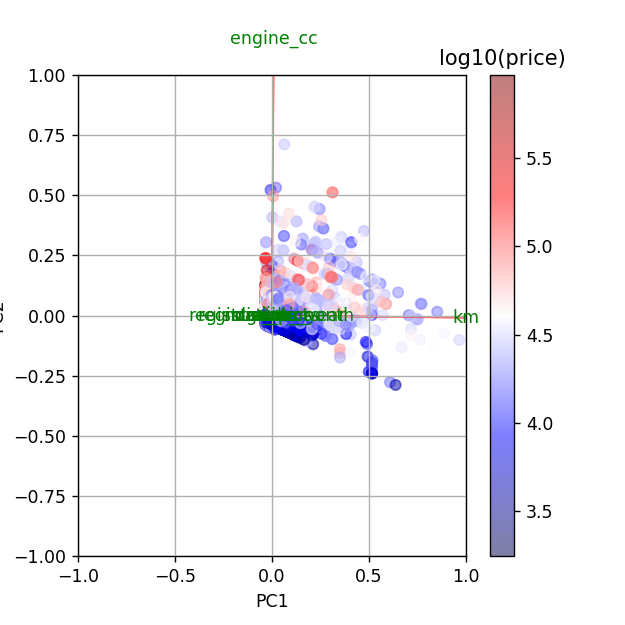

In [189]:
# Replot PCA components
pca_fig = plt.figure('PCA Biplot with Cleaned Data',figsize=(5,5))

biplot(reduced[:,0:2],np.transpose(pca.components_[0:2, :]), cont_vars)
plt.show()

### Interpreting PCA results

Our data cleaning did seem affect the variance explained by the second component, but the first component is still explaining around 99% of the varaince. This could be simply due to how the data is structured and not due to errors or outliers. 

When looking at the biplot, you can see there are roughly two clusters formed between expensive (red) and cheaper cars (blue). Cheaper cars tend to have higher values for `km` and `engine_cc` than more expensive cars. These two traits are believable if a majority of less expensive cars are comprised of used trucks, which probably have high milages and larger engines.

Conversely, more expensive cars tend to have lower values for `km` and `engine_cc`. In other words, more expensive cars are likely newer (i.e. have less miles) and have smaller engines like a sports car would.

`km` will likely play an important role in our predictive model.

### Training Data

Finally, we will be saving our final, cleaned dataset to a .csv file. We will only be chosing numerical columns for the final dataset.

Additionally, we will be removing columns that we consider as potentially causing data leakage--such as `num_pics` or `discount`. It is not possible to filter car results on Cars From Japan using such variables, and it would be something difficult to establish beforehand (e.g. look for cars with only n amount of pictures will probably be cumbersome).

We will also be removing `grade` for concerns about missing data.

In [190]:
# Saving datasets for modeling
model_training_cols = ['km', 'engine_cc', 'price', 'seats', 
       'num_doors', 'dim', 'registration_year', 'sedan', 
       'minivan','truck','SUV','hatchback', 'convertible', 
       'coupe', 'mini_vehicle','Manual','Automatic', 'Cvt', 
       '2WD', '4WD', 'Petrol', 'Diesel', 'Hybrid']


# Save to csv
JDM_df[model_training_cols].to_csv('modeling_data.csv', index=False)